In [19]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Permute
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten, Reshape, Dropout
from keras.utils import to_categorical
from keras.layers import Activation
from keras import regularizers
from keras.layers import Lambda

from keras.regularizers import l2

import kapre 
from kapre.time_frequency import Spectrogram

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

from itertools import islice

from UtilNNDL import create_window_data
from UtilNNDL import plot_hist
from UtilNNDL import prepare_data
from UtilNNDL import plot_confusion_matrix
from UtilNNDL import bandpass_cnt
from UtilNNDL import exponential_running_standardize

In [2]:
#Prepare the data by taking out nans and dividing into test and train
file_path = 'datasets/'
file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =1)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(237, 22, 1000)
(237, 4)
(50, 22, 1000)
(50, 4)


In [3]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(237, 1000, 22)
(50, 1000, 22)
(237, 1000, 22)
(50, 1000, 22)


In [4]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

(237, 22, 1000)
(50, 22, 1000)


In [5]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(2370, 22, 512)
(2370, 4)
(500, 22, 512)
(500, 4)


In [6]:
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(2370, 22, 512)
(2370, 4)
(500, 22, 512)
(500, 4)


In [7]:
#STFT CNN

SR = 250
src_cute, _ = librosa.load(r'/home/carla/Downloads/SampleAudio_0.4mb.mp3', sr=SR, mono=True)

def print_info():
    print('%s/%s/%s' % (now.year, now.month, now.day))
    print('librosa version: {}'.format(librosa.__version__))
    print('Keras version: {}'.format(keras.__version__))
    if keras.backend._BACKEND == 'tensorflow':
        import tensorflow
        print('Keras backend: {}: {}'.format(keras.backend._backend, tensorflow.__version__))
    elif keras.backend._BACKEND == 'theano':
        import theano
        print('Keras backend: {}: {}'.format(keras.backend._backend, theano.__version__))
    print('Keras image data format: {}'.format(keras.backend.image_data_format()))
    print('Kapre version: {}'.format(kapre.__version__))
    print('\nSampling rate: {} Hz'.format(SR))

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])
    
    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    np.random.seed(42)
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, data, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print "Channels"
    print model.input_shape[1:]
    src = data 
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    print src_batch.shape
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    
    if logam:
        result = librosa.amplitude_to_db(result)
    display.specshow(result, 
                     y_axis='linear', sr=SR)

srcshape
(22, 512)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
trainable_stft (Spectrogr (None, 257, 32, 22)       263168      
Total params: 263,168
Trainable params: 263,168
Non-trainable params: 0
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 1s 573ms/step - loss: 1194.4502
Channels
(22, 512)
(1, 22, 512)
[ 0.  0.  0.  1.]


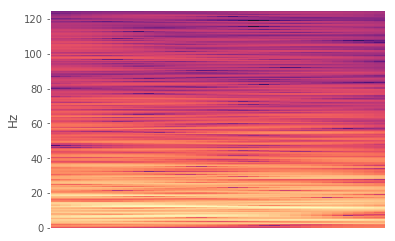

In [8]:
#Show the output of the model after STFT
src = train_data_sliced[0]
#src = databuf[0,0,:]
#src = src[np.newaxis, :] 
print "srcshape"
print src.shape
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=16, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))

check_model(model)
visualise_model(model, src)
print train_labels_sliced[1]

In [9]:
test_data_sliced = test_data_sliced[:500,:]
test_labels_sliced = test_labels_sliced[:500,:]
print test_data_sliced.shape
print test_labels_sliced.shape 

(500, 22, 512)
(500, 4)


In [10]:
traindata2d = train_data_sliced.reshape(train_data_sliced.shape[0], train_data_sliced.shape[2], train_data_sliced.shape[1], 1)
testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
print traindata2d.shape
print testdata2d.shape

(2370, 512, 22, 1)
(500, 512, 22, 1)


# TESTING


deepconvnet no regularization

In [28]:
num_filters = 10
"""
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=8, input_shape=train_data_sliced[0].shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))
model.add(Conv2D(24, kernel_size=(25,1), data_format='channels_last', input_shape=(257, 64, 22), 
                 kernel_initializer='glorot_normal')) 
model.add(Conv2D(24, kernel_size=(1,22), activation='relu', kernel_initializer='glorot_normal') ) 
model.add(BatchNormalization(axis=-1))
model.add(Lambda(lambda x: x ** 2))
model.add(MaxPooling2D(pool_size=(60,1), strides = (15,1)))

#model.add(Dropout(0.8))
model.add(Flatten())

model.add(Dense(4, activation='softmax',kernel_initializer='glorot_normal'))#, kernel_regularizer=regularizers.l2(0.05)))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=8,validation_split=0.25,batch_size=16)
"""

model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=8, input_shape=train_data_sliced[0].shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))

model.add(Conv2D(num_filters, kernel_size=(num_filters,1), activation='relu', data_format='channels_last'))
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu') ) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*8, kernel_size=(4,num_filters*4), activation='relu')) 
model.add(Reshape((num_filters*8,1)))
#model.add(LSTM(100, return_sequences=True))
#model.add(LSTM(32))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=8)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_stft (Spectrogram) (None, 257, 64, 22)       263168    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 248, 64, 10)       2210      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 234, 55, 10)       15010     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 78, 55, 10)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 78, 10, 55)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 69, 1, 20)         110020    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 1, 20)         0         
__________

KeyboardInterrupt: 

500/500 [==============================] - 0s 437us/step
Test Score: [1.8094149484634399, 0.51200000000000001]


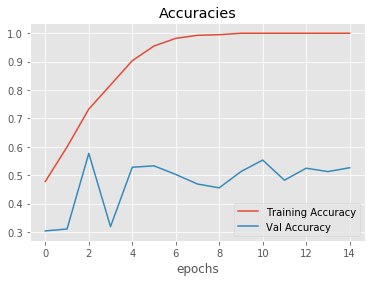

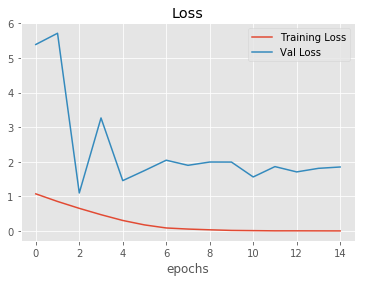

In [17]:
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=32)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

Trying out:
    * X batchnorm before nonlinearity
    * X regularization
    * dropout 0.5 applied to inputs to conv layers after the first
    * “new tied loss function” for further regularization

In [29]:
num_filters = 20 #15 performs similar
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=8, input_shape=train_data_sliced[0].shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), data_format='channels_last', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal') ) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
#model.add(LSTM(32, return_sequences=True))

model.add(Flatten())
model.add(Dense(4, activation='softmax', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(traindata2d,train_labels_sliced,epochs=30,validation_split=0.25,batch_size=16)
#model.test_on_batch(test_data, test_labels)


ValueError: Negative dimension size caused by subtracting 10 from 4 for 'conv2d_26/convolution' (op: 'Conv2D') with input shapes: [?,4,80,1], [10,80,1,160].

500/500 [==============================] - 0s 487us/step
Test Score: [1.4048733182847499, 0.58799999999999997]


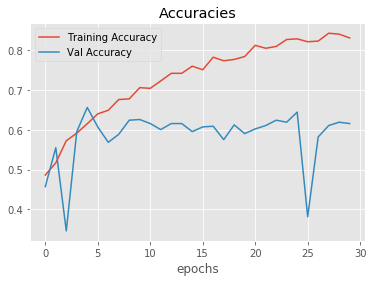

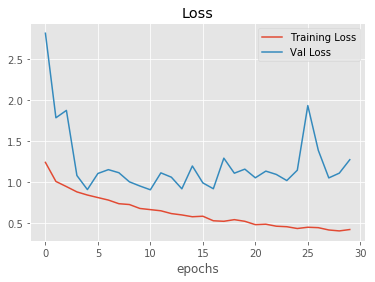

In [74]:
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=16)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')